In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-bert/dataset_sentiment_updated_3labels.xlsx
/kaggle/input/dataset-tachygraphy/Tachygraphy_EmotionMoodtags_Dataset.csv
/kaggle/input/dataset-tachygraphy/Tachygraphy_MicroText-AIO-V3.xlsx
/kaggle/input/dataset-tachygraphy/Tachygraphy_MicroText-AIO-Emotion_Mood_Tags-V3.xlsx
/kaggle/input/dataset-tachygraphy/Tachygraphy_dataset_main.csv
/kaggle/input/dataset-tachygraphy/Tachygraphy_MicroText-AIO-Sentiment_Polarities_3_Label-V3.xlsx
/kaggle/input/dataset-tachygraphy/Tachygraphy_MicroText-AIO-Sentiment_Polarities_2_Label-V3 (Neutral Omitted).xlsx
/kaggle/input/dataset-tachygraphy/Tachygraphy_MicroText-AIO-V2.xlsx
/kaggle/input/dataset-sentiment-new/dataset_sentiment_updated.xlsx
/kaggle/input/data-sentiment-final/dataset_sentiment_updated.xlsx
/kaggle/input/sentiment-data/polarity_leveled_dataset (1).csv


**Text Preprocessing**

In [8]:
# To ignore warinings
import warnings
warnings.filterwarnings('ignore')

In [9]:
import pandas as pd
df=pd.read_excel("/kaggle/input/dataset-bert/dataset_sentiment_updated_3labels.xlsx")
df.shape

(10280, 3)

In [10]:
df.head()

,Informal Text,Expanded Meaning,Sentiment
0,"omg, JEE prep is killing me rn",oh my god joint entrance examination preparati...,negative
1,u up 4 a break b4 UPSC revision?,are you up for a break before union public ser...,neutral
2,"ttyl, finishing da CAT mock",talk to you later finishing the common admissi...,neutral
3,"nah, dat GATE paper was brutal af",no that graduate aptitude test in engineering ...,negative
4,sup? u done w/ ur IIT assignment?,whats up are you done with your indian institu...,neutral


In [11]:
df=df.drop('Expanded Meaning',axis=1)
df = df.rename(columns={'Informal Text': 'tweet'})
df = df.rename(columns={'Sentiment': 'class'})
df['class'] = df['class'].str.lower()
sentiment_counts = df['class'].value_counts()
sentiment_counts

class
negative    4224
neutral     3351
positive    2705
Name: count, dtype: int64

In [12]:
df.isnull().sum()

tweet    2
class    0
dtype: int64

In [13]:
df=df.fillna('')

In [14]:
import re
from bs4 import BeautifulSoup

def text_cleaning(text):
    text = str(text)
    soup = BeautifulSoup(text, "html.parser")    ###removing html tages
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())      ##removing text within square brackets
    pattern = r"[^a-zA-Z0-9\s,']"                  # Removing unwanted characters
    text = re.sub(pattern, '', text)
    url_pattern = r'http\S+|www\S+'            ###removing urls
    text = re.sub(url_pattern, '', text)
    return text

In [15]:
df['tweet']=df['tweet'].apply(text_cleaning).tolist()

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import re

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [19]:
df['tweet'].dtype

dtype('O')

In [20]:
df['class'].dtype

dtype('O')

In [21]:
df.tail(10)

,tweet,class
10270,"wtf, new iPhones out tmrw, ppl lining up already",negative
10271,"yo, BMCs new MUM projects, finally some progress",positive
10272,"bruh, Jios 5G speeds, insane levels",positive
10273,"wtf, new law on plastics, finally some action",negative
10274,"yo, Delhis air quality, smog everywhere, its bad",negative
10275,"bruh, UPs power cuts, no relief in sight",negative
10276,"wtf, new tax laws hitting hard, prices gonna j...",negative
10277,"yo, Adanis stock falling, more issues surfacing",negative
10278,"bruh, tech IPOs doing well, investors excited",positive
10279,"wtf, Delhis AQI at record highs, air quality t...",negative


In [22]:
#df = df[df['class'] != "neutral"]  ###droping neutral columns
df['tweet'] = df['tweet'].apply(lambda x: x.lower())

print(df[ df['class'] == 'positive'].size)
print(df[ df['class'] == 'negative'].size)

for idx,row in df.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['tweet'].values)
X = tokenizer.texts_to_sequences(df['tweet'].values)
X = pad_sequences(X)

5410
8448


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import RMSprop
from keras_tuner import RandomSearch

In [24]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-03-15 19:02:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-03-15 19:02:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-15 19:02:01--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [25]:
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs


In [20]:
# max_features = 5000  
# embed_dim = 128 
# lstm_out = 64  
# batch_size = 32
# epochs = 20
# learning_rate = 0.001

In [26]:
max_features = 5000  
embed_dim = 128 
lstm_out = 64  
batch_size = 64
epochs = 20
initial_learning_rate = 0.0005

In [27]:
embedding_dim = 100
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_features:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [23]:
# # from tensorflow.keras.models import Sequential
# # from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense


# # Model
# model = Sequential()
# model.add(Embedding(max_features, embedding_dim, embeddings_initializer=Constant(embedding_matrix),
#                     input_length=X.shape[1], trainable=True))
# model.add(SpatialDropout1D(0.3))
# model.add(Bidirectional(LSTM(128, return_sequences=True)))
# model.add(LSTM(64, dropout=0.4, recurrent_dropout=0.4))
# model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
# model.add(Dropout(0.4))
# model.add(Dense(2, activation='softmax'))  # Assuming 2 classes for classification

# # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# # print(model.summary())

In [28]:
tf.random.set_seed(42)

In [25]:
# optimizer = Adam(learning_rate=initial_learning_rate)

In [26]:
# model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

In [27]:
# print(model.summary())

In [28]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, verbose=1)
# model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')


In [29]:
Y = pd.get_dummies(df['class']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8224, 30) (8224, 3)
(2056, 30) (2056, 3)


In [30]:
validation_size = 500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]

# MODEL

In [31]:
# Define the hyperparameter tuning function
def build_model(hp):
    model = Sequential()
    
    # Embedding layer with pre-trained GloVe embeddings
    model.add(Embedding(max_features,
                        embedding_dim,
                        embeddings_initializer=Constant(embedding_matrix),
                        input_length=X.shape[1],
                        trainable=True))
    
    # Tuning SpatialDropout1D rate
    model.add(SpatialDropout1D(hp.Float('spatial_dropout', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Bidirectional LSTM layer with tunable units
    model.add(Bidirectional(LSTM(units=hp.Int('lstm_units_1', min_value=64, max_value=128, step=32), 
                                 return_sequences=True)))
    
    # Second LSTM layer with dropout and recurrent dropout
    model.add(LSTM(units=hp.Int('lstm_units_2', min_value=32, max_value=64, step=32),
                   dropout=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1),
                   recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Dense layer with L2 regularization
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=64, step=16),
                    activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    
    # Dropout layer
    model.add(Dropout(hp.Float('dropout_dense', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(3, activation='softmax')) #for no of classes prev was 2
    
    # Compile the model
#     model.compile(
#         optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )
    
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [32]:
# Instantiate the RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Number of different models to try
    executions_per_trial=4,  # Number of times to train each model
    directory='my_dir',
    project_name='lstm_hyperparameter_tuning'
)

In [33]:

# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 8
spatial_dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lstm_units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
lstm_units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
recurrent_dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout_dense (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_valu

In [34]:
# batch_size = 32
# model.fit(X_train, Y_train, epochs = 20, batch_size=batch_size, verbose = 2)

# Training
# history = model.fit(X_train, Y_train,
#                     epochs=epochs,
#                     batch_size=batch_size,
#                     validation_data=(X_test, Y_test),
#                     verbose=2,
#                     callbacks=[early_stopping, reduce_lr, model_checkpoint])

In [34]:
# Perform hyperparameter tuning
tuner.search(X_train, Y_train, 
             epochs=20, 
             validation_data=(X_test, Y_test), 
             batch_size=64, 
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])


Trial 20 Complete [00h 03m 36s]
val_accuracy: 0.7543380409479141

Best val_accuracy So Far: 0.7564267218112946
Total elapsed time: 01h 50m 51s


## BEST HYPERPARAMS AS PERR TUNER

In [35]:
# Display best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=3)[0]
print(f"""
The hyperparameter search is complete. 
Optimal SpatialDropout1D rate: {best_hps.get('spatial_dropout')}
Optimal LSTM units for first layer: {best_hps.get('lstm_units_1')}
Optimal LSTM units for second layer: {best_hps.get('lstm_units_2')}
Optimal dropout rate for second LSTM layer: {best_hps.get('dropout')}
Optimal recurrent dropout rate for second LSTM layer: {best_hps.get('recurrent_dropout')}
Optimal dense layer units: {best_hps.get('dense_units')}
Optimal dropout rate for dense layer: {best_hps.get('dropout_dense')}
Optimal learning rate: {best_hps.get('learning_rate')}
""")



The hyperparameter search is complete. 
Optimal SpatialDropout1D rate: 0.5
Optimal LSTM units for first layer: 64
Optimal LSTM units for second layer: 64
Optimal dropout rate for second LSTM layer: 0.2
Optimal recurrent dropout rate for second LSTM layer: 0.30000000000000004
Optimal dense layer units: 48
Optimal dropout rate for dense layer: 0.30000000000000004
Optimal learning rate: 0.0017272834861040754



## SECOND BEST HYPERPARAMS AS PER TUNER

In [36]:
# Display 2nd best hyperparameters
best_hps2 = tuner.get_best_hyperparameters(num_trials=3)[1]
print(f"""
The hyperparameter search is complete. 
Optimal SpatialDropout1D rate: {best_hps2.get('spatial_dropout')}
Optimal LSTM units for first layer: {best_hps2.get('lstm_units_1')}
Optimal LSTM units for second layer: {best_hps2.get('lstm_units_2')}
Optimal dropout rate for second LSTM layer: {best_hps2.get('dropout')}
Optimal recurrent dropout rate for second LSTM layer: {best_hps2.get('recurrent_dropout')}
Optimal dense layer units: {best_hps2.get('dense_units')}
Optimal dropout rate for dense layer: {best_hps2.get('dropout_dense')}
Optimal learning rate: {best_hps2.get('learning_rate')}
""")


The hyperparameter search is complete. 
Optimal SpatialDropout1D rate: 0.5
Optimal LSTM units for first layer: 96
Optimal LSTM units for second layer: 32
Optimal dropout rate for second LSTM layer: 0.4
Optimal recurrent dropout rate for second LSTM layer: 0.4
Optimal dense layer units: 64
Optimal dropout rate for dense layer: 0.2
Optimal learning rate: 0.00401501974086681



In [ ]:
# # Display best hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# print(f"""
# The hyperparameter search is complete. 
# Optimal dropout rate: {best_hps.get('dropout_rate')}
# Optimal LSTM units: {best_hps.get('lstm_units')}
# Optimal dense layer units: {best_hps.get('dense_units')}
# Optimal optimizer: {best_hps.get('optimizer')}
# """)

In [37]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the final model
history = model.fit(X_train, Y_train, 
                    epochs=20, 
                    validation_data=(X_test, Y_test), 
                    batch_size=64, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.4636 - loss: 1.4010 - val_accuracy: 0.6298 - val_loss: 0.8994
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6170 - loss: 0.9070 - val_accuracy: 0.6787 - val_loss: 0.7474
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.6892 - loss: 0.7438 - val_accuracy: 0.7294 - val_loss: 0.6694
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.7211 - loss: 0.6753 - val_accuracy: 0.7429 - val_loss: 0.6534
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.7595 - loss: 0.6115 - val_accuracy: 0.7513 - val_loss: 0.6416
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7676 - loss: 0.5899 - val_accuracy: 0.7532 - val_loss: 0.6288
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7802 - loss: 0.5616 - val_accuracy: 0.7532 - val_loss: 0.6324
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7934 - loss: 0.5256 - val_acc

In [38]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_acc:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7415 - loss: 0.6562
Test accuracy: 0.7487


In [ ]:
# Build the model with the 2nd best hyperparameters
model2 = tuner.hypermodel.build(best_hps2)

# Train the final model
history = model2.fit(X_train, Y_train, 
                    epochs=20, 
                    validation_data=(X_test, Y_test), 
                    batch_size=64, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

In [ ]:
# Evaluate the 2nd model
test_loss, test_acc = model2.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_acc:.4f}")

In [39]:
score,acc = model.evaluate(X_test, Y_test,verbose = 2, batch_size = batch_size)
print("loss_score: %.2f" % (score))
print("accuracy: %.2f" % (acc))

25/25 - 0s - 17ms/step - accuracy: 0.7487 - loss: 0.6517
loss_score: 0.65
accuracy: 0.75


In [ ]:
# pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
# for x in range(len(X_validate)):
    
#     result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
#     if np.argmax(result) == np.argmax(Y_validate[x]):
#         if np.argmax(Y_validate[x]) == 0:
#             neg_correct += 1
#         else:
#             pos_correct += 1
       
#     if np.argmax(Y_validate[x]) == 0:
#         neg_cnt += 1
#     else:
#         pos_cnt += 1



# print("pos_acc", pos_correct/pos_cnt*100, "%")
# print("neg_acc", neg_correct/neg_cnt*100, "%")

In [ ]:
twt = ['I been told you that yo folks dont care about you . Im starving and my dad deadass didnt make me a plate']
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

In [40]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define sentiment labels
sentiment_labels = ["Negative", "Neutral", "Positive"]

# Example input text
twt = ['I been told you that yo folks dont care about you . Im starving and my dad deadass didnt make me a plate']

# Tokenize and pad the input text
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)

# Predict sentiment
sentiment = model.predict(twt, batch_size=1, verbose=2)[0]

# Get predicted class index
predicted_class = np.argmax(sentiment)

# Print the predicted sentiment
print(f"Predicted Sentiment: {sentiment_labels[predicted_class]}")

1/1 - 0s - 415ms/step
Predicted Sentiment: Negative


In [41]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define sentiment labels
sentiment_labels = ["Negative", "Neutral", "Positive"]

# Example input text
twt = ['ggs! hv to go now, hv xm tmrw!!']

# Tokenize and pad the input text
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)

# Predict sentiment
sentiment = model.predict(twt, batch_size=1, verbose=2)[0]

# Get predicted class index
predicted_class = np.argmax(sentiment)

# Print the predicted sentiment
print(f"Predicted Sentiment: {sentiment_labels[predicted_class]}")

1/1 - 0s - 34ms/step
Predicted Sentiment: Positive


In [43]:
model.save('lstm_model.h5')

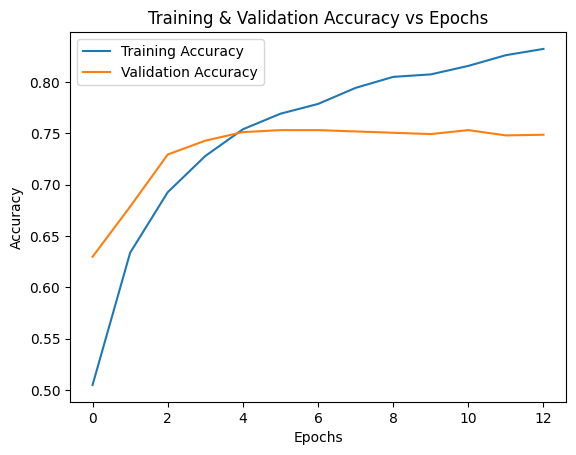

In [44]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy vs Epochs')
plt.legend()
plt.savefig("/kaggle/working/fig1.png")
plt.show()


In [45]:
if 'lr' in history.history:
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs Epochs')
    plt.legend()
    plt.savefig("/kaggle/working/fig2.png")
    plt.show()
else:
    print("Learning rate data not found in history.")


Learning rate data not found in history.


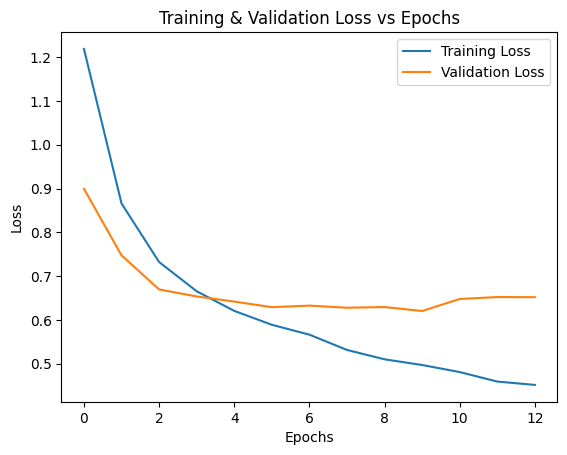

In [46]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss vs Epochs')
plt.legend()
plt.savefig("/kaggle/working/fig3.png")
plt.show()


In [47]:
if 'lr' in history.history:
    plt.plot(history.history['lr'], history.history['loss'], label='Training Loss')
    plt.plot(history.history['lr'], history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss vs Learning Rate')
    plt.legend()
    plt.xscale('log')  # Use log scale for better visualization
    plt.savefig("/kaggle/working/fig4.png")
    plt.show()
else:
    print("Learning rate data not found in history.")


Learning rate data not found in history.


In [57]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
#secret_value_0 = user_secrets.get_secret("HF_READ_TOKEN")
secret_value_1 = user_secrets.get_secret("HF_READ_WRITE_TOKEN")

In [59]:
from huggingface_hub import login

login(token=user_secrets.get_secret("HF_READ_WRITE_TOKEN"))

In [61]:
import pickle
# Save tokenizer using pickle
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [66]:
from huggingface_hub import HfApi, upload_file

# Define your repo ID (existing Hugging Face repo)
repo_id = "tachygraphy-microtrext-norm-org/LSTM-LV1-SentimentPolarities"  # Replace with your actual repo name

# Initialize API instance
api = HfApi()

# Upload LSTM model
upload_file(
    path_or_fileobj="/kaggle/working/lstm_model.h5",
    path_in_repo="lstm.h5",
    repo_id=repo_id,
    repo_type="model",
    token=hf_token
)

# Upload Tokenizer
upload_file(
    path_or_fileobj="/kaggle/working/tokenizer.pickle",
    path_in_repo="tokenizer.pickle",
    repo_id=repo_id,
    repo_type="model",
    token=hf_token
)

print(f"✅ Model and tokenizer uploaded to {repo_id}")

lstm_model.h5:   0%|          | 0.00/17.4M [00:00<?, ?B/s]

tokenizer.pickle:   0%|          | 0.00/483k [00:00<?, ?B/s]

✅ Model and tokenizer uploaded to tachygraphy-microtrext-norm-org/LSTM-LV1-SentimentPolarities
